# Frame the Problem

Predict who survived the sinking of *The Titanic*. 

# Install and Load the Libraries

In [1]:
# %pip install seaborn
# %pip install xgboost
# %pip install -U scikit-learn

# Restart your kernel 


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Load the Data

In [3]:
titanic = sns.load_dataset('titanic')

# Conduct Exploratory Data Analysis

In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


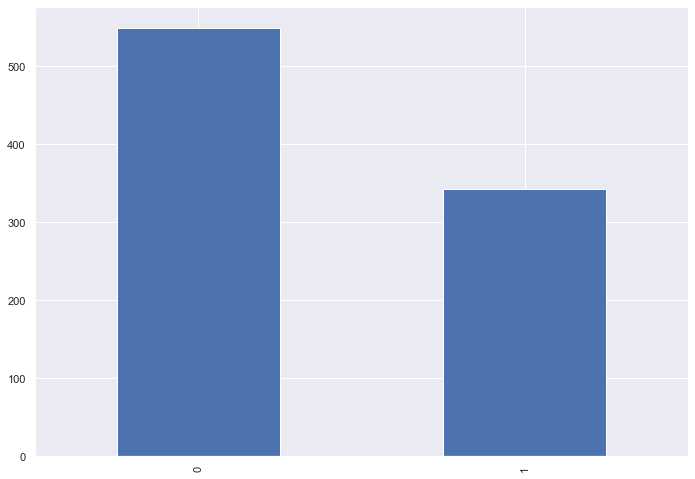

In [6]:
titanic.survived.value_counts().plot(kind='bar');

# Prepare the data 

In [7]:
titanic['is_female'] = np.where(titanic['sex'] == 'female', 1, 0)

What about missing values? 

XGBoost can handle them by [default](https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values) but do this with care. 

In [8]:
keep = ['pclass', 'is_female', 'sibsp', 'parch', 'fare']

X = titanic.loc[:, keep]
y = titanic.loc[:, 'survived']

In [9]:
# Train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

# Build and Evaluate the model  

In [10]:
# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, random_state=RANDOM_STATE)

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [11]:
xgb_clf.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), 
                      (X_test, y_test)],
            verbose=10)

preds = xgb_clf.predict(X_test)


[20:13:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.55694	validation_1-logloss:0.57536
[10]	validation_0-logloss:0.32656	validation_1-logloss:0.46347
[20]	validation_0-logloss:0.29136	validation_1-logloss:0.49204
[30]	validation_0-logloss:0.27363	validation_1-logloss:0.51765
[40]	validation_0-logloss:0.26055	validation_1-logloss:0.53675
[50]	validation_0-logloss:0.25271	validation_1-logloss:0.54458
[60]	validation_0-logloss:0.24498	validation_1-logloss:0.55690
[70]	validation_0-logloss:0.23988	validation_1-logloss:0.56390
[80]	validation_0-logloss:0.23434	validation_1-logloss:0.57591
[90]	validation_0-logloss:0.22953	validation_1-logloss:0.59446
[99]	validation_0-logloss:0.22537	validation_1-logloss:0.60911


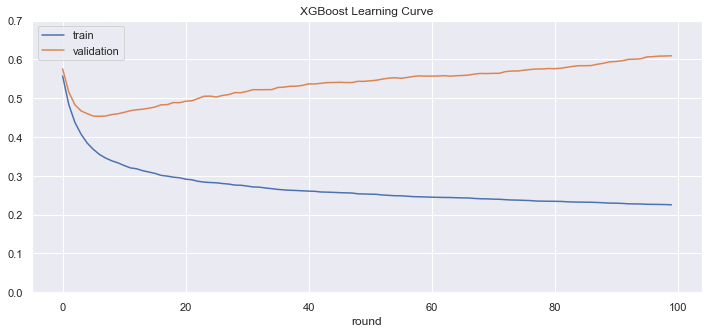

In [12]:
#Plot the Learning Curve
evals_result = xgb_clf.evals_result()

train_errors = evals_result['validation_0']['logloss']

validation_errors = evals_result['validation_1']['logloss']

df = pd.DataFrame([train_errors, validation_errors]).T

df.columns = ['train', 'validation']

df.index.name = 'round'

df.plot(title='XGBoost Learning Curve', ylim=(0, 0.7), figsize=(12, 5));

The accuracy score for XGBClassifier is: 0.7728813559322034


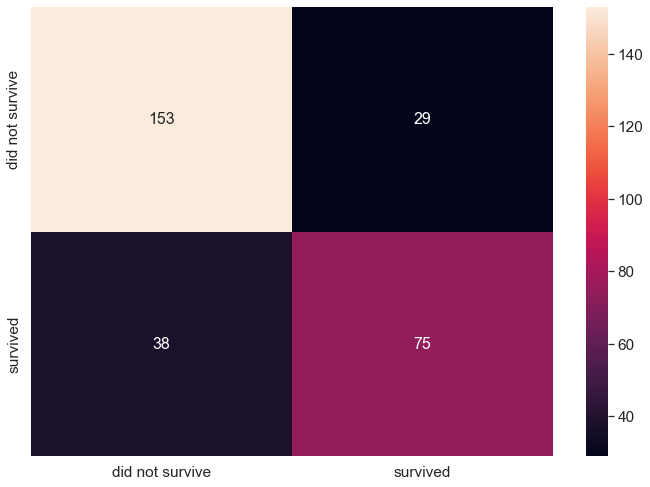

In [13]:
print(f'The accuracy score for XGBClassifier is:', xgb_clf.score(X_test,y_test))

cm_array = confusion_matrix(y_test, preds, labels=[0,1])


label_names = ['did not survive', 'survived']

df_cm = pd.DataFrame(cm_array, 
                     index=label_names, 
                     columns=label_names)

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16}); # font size

# Inspect the Feature Importance

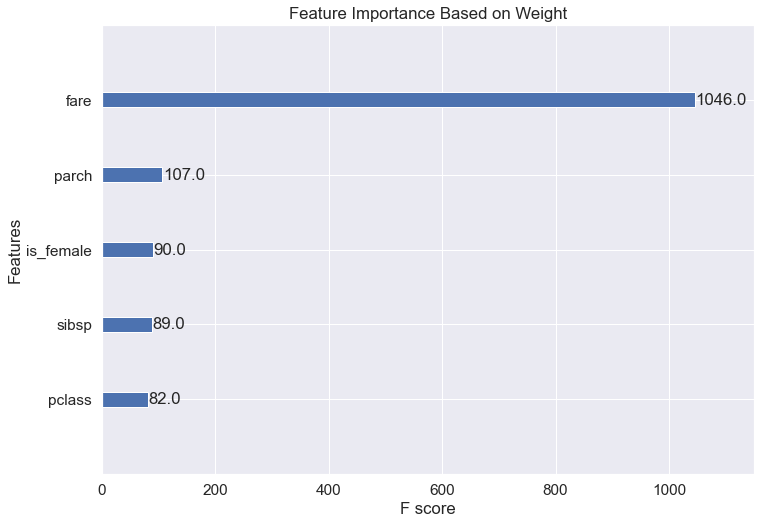

In [32]:
# How many times a feature appears in a tree
xgb.plot_importance(xgb_clf, 
                    importance_type='weight', 
                    max_num_features=5,
                    title='Feature Importance Based on Weight',);

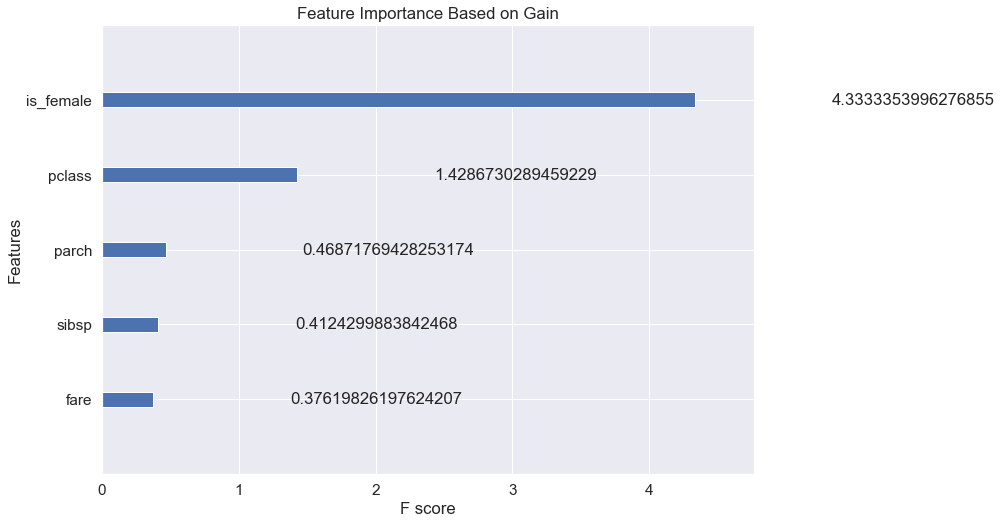

In [31]:
# What is the average gain of splits for each feature?
xgb.plot_importance(xgb_clf, 
                    importance_type='gain', 
                    max_num_features=5, 
                    title='Feature Importance Based on Gain');

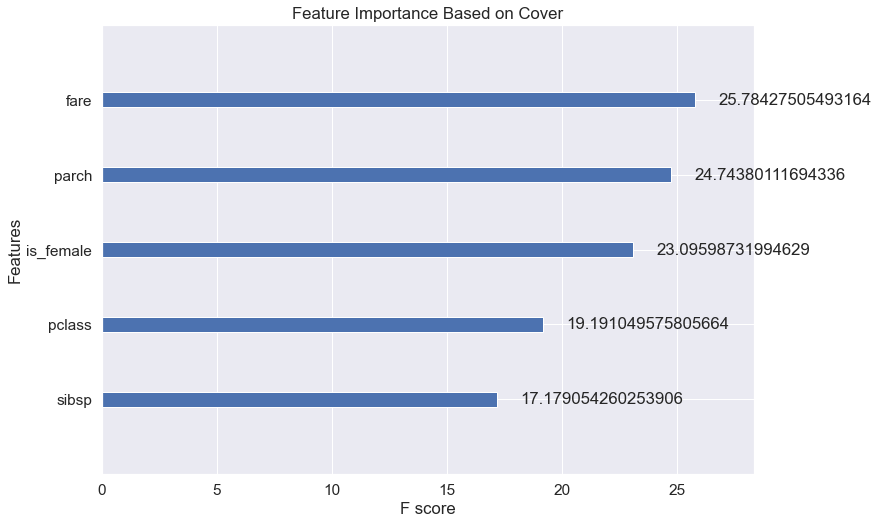

In [30]:
xgb.plot_importance(xgb_clf, max_num_features=5, importance_type='cover', title='Feature Importance Based on Cover'); 